In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#Import confussion matrix per taxonomy level
cmOrder = pd.read_csv("Order300320/confussionMatrix.csv",header=0,index_col=0,sep='\t')
cmFamily = pd.read_csv("Family300320/confussionMatrix.csv",header=0,index_col=0,sep='\t')
cmGenus = pd.read_csv("Genus300320/confussionMatrix.csv",header=0,index_col=0,sep='\t')

In [3]:
def sampler(matrix):
    median = getMedian(matrix)
    #median = matrix["Labels"].value_counts().min()
    lenSample = median/2
    trainIndex = np.array([])
    testIndex = np.array([])
    for label in matrix["Labels"].unique():
        indexLabel = matrix[matrix["Labels"]==label].index.values
        np.random.shuffle(indexLabel)
        if indexLabel.shape[0]>= median:
            trainIndex = np.concatenate((trainIndex,indexLabel[:lenSample]))
            testIndex = np.concatenate((testIndex,indexLabel[lenSample*(-1):]))
        else:
            trainIndex = np.concatenate((trainIndex,bootstrap_resample(indexLabel[:(indexLabel.shape[0]/2)+1],lenSample)))
            testIndex = np.concatenate((testIndex,bootstrap_resample(indexLabel[indexLabel.shape[0]/2:])))
    return trainIndex,testIndex

In [4]:
def getMedian(matrix):
    numLabels = matrix["Labels"].unique()
    if len(numLabels)%2 == 0:
        counts = matrix["Labels"].value_counts().tolist()
        return (count[(len(numLabels)/2)-1]+counts[len(numLabels)/2])/2
    else:
        return matrix["Labels"].value_counts().tolist()[((len(numLabels)+1)/2)-1]

In [5]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

In [6]:
def getMissclassificationCases(cm):
    missclassification = []
    for index,row in cm.iterrows():
        row = row[row>0]
        for i,x in row.iteritems():
            if i != index:
                missclassification.append((index,i,x))
    missDF = pd.DataFrame(missclassification,columns=["Label","Prediction","MissRate"])
    missDF = missDF.sort_values(by="MissRate",ascending=False)
    return missDF

In [7]:
missDFs = []
for cm in [cmOrder,cmFamily,cmGenus]:
    missDFs.append(getMissclassificationCases(cm))

#Attach a column that indicates the taxonomic level
missDFs[0]["Level"] = ["Order"]*missDFs[0].shape[0]
missDFs[1]["Level"] = ["Family"]*missDFs[1].shape[0]
missDFs[2]["Level"] = ["Genus"]*missDFs[2].shape[0]

#Combine all dataframes in one dataframe
missclassification = pd.concat(missDFs)
missclassification["MissRate"] = missclassification["MissRate"]*100 

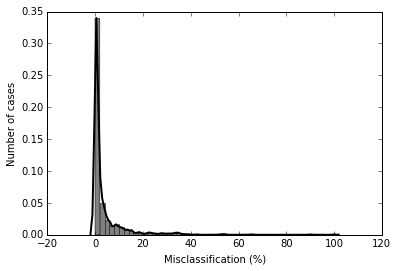

In [8]:
ax = sns.distplot(missclassification["MissRate"],
                  kde_kws={"color": "k", "lw": 2},
                  hist_kws={"histtype": "bar", "linewidth": 0.5,"alpha": 1, "color": "grey"})
ax.set_xlabel(xlabel="Misclassification (%)")
ax.set_ylabel(ylabel="Number of cases")
ax.figure.savefig("classificationError/ce_distribution.pdf")

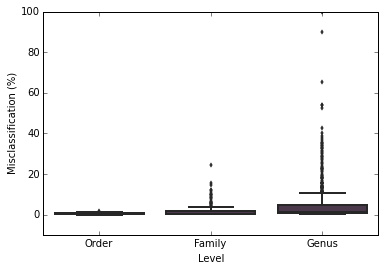

In [9]:
flierprops = dict(markerfacecolor='0.75', markersize=2,color="grey",
              linestyle='none')

ax = sns.boxplot(x="Level",y="MissRate",data=missclassification,color="#4c364d",
                 linewidth=2,fliersize=3)

#ax = sns.swarmplot(x='Level',y='MissRate',data=missclassification,color="grey")
ax.set_ylim(-10,100)
ax.set_ylabel("Misclassification (%)")
ax.figure.savefig("classificationError/ce_perTaxonomicLevel.pdf")

In [8]:
#Get the number of genomes per label for each classification task
#Remember:
#Genomes were reduced to the median of all genomes per label
#if the number of genomes was less than the median, genomes were bootstraped
#The idea here is to get the number of genomes per label in the original matrix
#And the number of unique genomes per label in a train matrix

originalMatrixPath = ["Order300320/reducedViphogsMatrix.csv",
                      "Family300320/reducedViphogsMatrix.csv",
                      "Genus300320/reducedViphogsMatrix.csv"]
genomesCounts = []
for matrix in originalMatrixPath:
    #Import original matrix
    matrix = pd.read_csv(matrix,header=0,sep='\t')
    #Get the nuber of genomes per label
    genomesPerlabel = matrix[[0,-1]].groupby(by="Labels").count()
    genomesPerlabel.reset_index(inplace=True)

    #Get the number of unique genomes
    #get a sample of a train matrix
    sampleTrainIndex, sampleTestIndex = sampler(matrix)
    #The sample is turn into a set to remove duplicates and then turn back to a list 
    genomesPerlabelInSample = matrix.iloc[list(set(sampleTrainIndex))][[0,-1]].groupby(by="Labels").count()
    genomesPerlabelInSample.reset_index(inplace=True)
    
    genomesCounts.append((genomesPerlabel,genomesPerlabelInSample))

In [9]:
labelsDictPath = ["Order/trainTestLabelsDictOrderAll.npy",
                  "Family/trainTestLabelsDictFamilyAll.npy",
                  "Genus/trainTestLabelsDictGenusAll.npy"]
labelsDict = []
for path in labelsDictPath:
    ldict = np.load(path).item()
    ldict = {v:k for k,v in ldict.iteritems()}
    labelsDict.append(ldict)

In [10]:
for i in range(len(genomesCounts)):
    for j in range(2):
        genomesCounts[i][j]["Labels"].update(pd.Series(labelsDict[i]))

In [11]:
#Check if the missclassification rate correlates with the number of genomes
#1.get the total missclassification rate per taxonomic group per taxonomic level
missSummaryDF = []
for df in missDFs:
    summary = df.groupby(by="Label").sum()["MissRate"].sort_values(ascending=False)*100
    summary = pd.DataFrame(summary).reset_index()
    missSummaryDF.append(summary)

In [12]:
level = ["Order","Family","Genus"]
for i in range(len(genomesCounts)):
    missSummaryDF[i] = missSummaryDF[i].merge(genomesCounts[i][0],
                                              how="right",left_on="Label",right_on="Labels")
    missSummaryDF[i].columns = ["Label","MissRate","x","GenomeCountsAll"]
    missSummaryDF[i] = missSummaryDF[i].merge(genomesCounts[i][1],
                                              how="right",left_on="x",right_on="Labels")
    missSummaryDF[i].columns = ["o","MissRate","x","GenomeCountsAll","Label","GenomeCountsSample"]
    missSummaryDF[i] = missSummaryDF[i][["Label","MissRate","GenomeCountsAll","GenomeCountsSample"]]
    missSummaryDF[i]["Level"] = level[i]

In [13]:
missSummaryDF = pd.concat(missSummaryDF)
missSummaryDF.fillna(0,inplace=True)

In [50]:
missSummaryDF[missSummaryDF["Label"].str.contains("Bafini")]

,Label,MissRate,GenomeCountsAll,GenomeCountsSample,Level,MissRateAdjusted
153,Bafinivirus,1,2,1,Genus,2


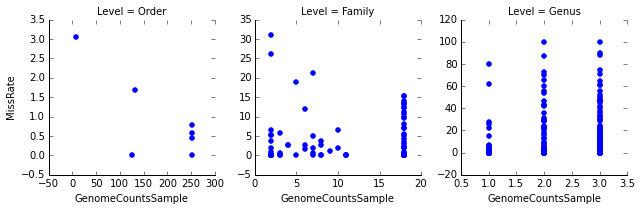

In [16]:
ax = sns.FacetGrid(missSummaryDF,col="Level",sharey=False,sharex=False)
ax.map(plt.scatter,"GenomeCountsSample","MissRate")

In [14]:
missSummaryDF["MissRateAdjusted"] = missSummaryDF["MissRate"]+1

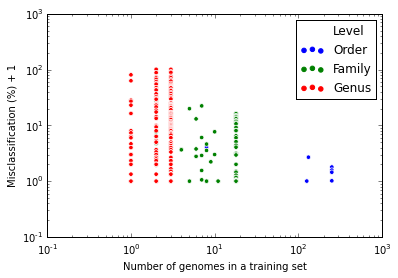

In [18]:
#Absolute classification error
ax = sns.scatterplot(x="GenomeCountsSample",y="MissRateAdjusted",hue="Level",data=missSummaryDF)
ax.semilogx()
ax.semilogy()
ax.set_ylabel(ylabel="Misclassification (%) + 1")
ax.set_xlabel(xlabel="Number of genomes in a training set")
ax.figure.savefig("classificationError/ce_NumGenomesPerSetvsError.pdf")

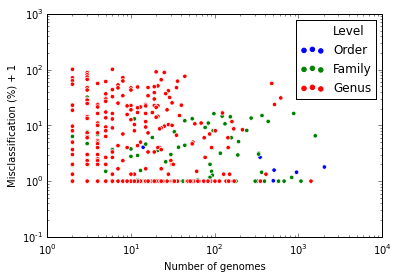

In [19]:
#Absolute classification error
ax = sns.scatterplot(x="GenomeCountsAll",y="MissRateAdjusted",hue="Level",data=missSummaryDF)
ax.semilogy()
ax.semilogx()
ax.set_ylabel(ylabel="Misclassification (%) + 1")
ax.set_xlabel(xlabel="Number of genomes")
ax.figure.savefig("classificationError/ce_NumGenomesVsError.pdf")

In [15]:
#Which groups have a missRate >10% and more than 100 genomes to sample?
missSummaryDF[(missSummaryDF["GenomeCountsAll"]>=100)&(missSummaryDF["MissRate"]>=10)].sort_values(by=["Level","MissRate"])

,Label,MissRate,GenomeCountsAll,GenomeCountsSample,Level,MissRateAdjusted
13,Hepadnaviridae,10.750000,436,18,Family,11.750000
9,Paramyxoviridae,12.500000,273,18,Family,13.500000
8,Polyomaviridae,13.250000,154,18,Family,14.250000
7,Caulimoviridae,13.611111,123,18,Family,14.611111
6,Podoviridae,14.000000,368,18,Family,15.000000
4,Flaviviridae,15.333333,881,18,Family,16.333333
85,Flavivirus,10.666667,161,3,Genus,11.666667
72,Orthopoxvirus,15.666667,124,3,Genus,16.666667
52,Begomovirus,22.666667,519,3,Genus,23.666667
40,Hepacivirus,30.000000,616,3,Genus,31.000000


In [100]:
#Which were the most comon confussion per level?
top10 = []
for level in ["Order","Family","Genus"]:
    top10.append(missclassification[missclassification["Level"]==level].sort_values(by="MissRate",ascending=False).head(10))

In [104]:
#Append number of genomes available
#Order case
aux = top10[0].merge(right=missSummaryDF,left_on="Label",right_on="Label",how='left')
aux = aux.merge(right=missSummaryDF,left_on="Prediction",right_on="Label",how='left')
aux = aux[["Label_x","GenomeCountsAll_x","GenomeCountsSample_x","Prediction","GenomeCountsAll_y","GenomeCountsSample_y","MissRate_x","Level_x"]].copy()
aux.columns = ["Label","GenomeCountsAll_l","GenomeCountsSample_l","Prediction","GenomeCountsAll_p","GenomeCountsSample_p","MissRate","Level"]
top10[0] = aux
##Family case
aux = top10[1].merge(right=missSummaryDF,left_on="Label",right_on="Label",how='left')
aux = aux.merge(right=missSummaryDF,left_on="Prediction",right_on="Label",how='left')
aux = aux[["Label_x","GenomeCountsAll_x","GenomeCountsSample_x","Prediction","GenomeCountsAll_y","GenomeCountsSample_y","MissRate_x","Level_x"]].copy()
aux.columns = ["Label","GenomeCountsAll_l","GenomeCountsSample_l","Prediction","GenomeCountsAll_p","GenomeCountsSample_p","MissRate","Level"]
top10[1] = aux
##Genus case
aux = top10[2].merge(right=missSummaryDF,left_on="Label",right_on="Label",how='left')
aux = aux.merge(right=missSummaryDF,left_on="Prediction",right_on="Label",how='left')
aux = aux[["Label_x","GenomeCountsAll_x","GenomeCountsSample_x","Prediction","GenomeCountsAll_y","GenomeCountsSample_y","MissRate_x","Level_x"]].copy()
aux.columns = ["Label","GenomeCountsAll_l","GenomeCountsSample_l","Prediction","GenomeCountsAll_p","GenomeCountsSample_p","MissRate","Level"]
top10[2] = aux


In [109]:
#Append the complete lineage to the top10 table. In order to see if the most comon confussion are due to close evlotuionary realtionships
###1. Import taxonomy table for all genomes
taxonomy = pd.read_csv("../../7_DBtests/iv_queries/taxonomyAnotation.csv")
taxonomy.head()
###2. Keep only Genus, Family and Order columns and remove duplicates
taxonomy = taxonomy[["Order","Family","Genus"]].copy()
taxonomy = taxonomy.drop_duplicates().copy()
taxonomy.head()
###3. Combine lineage and top10 table
##Order case is not needed as Order is the higher taxonomic label
##Family case
taxonomyFamily = taxonomy[["Order","Family"]].drop_duplicates().copy()
aux = top10[1].merge(right=taxonomyFamily,left_on="Label",right_on="Family",how="left")
aux = aux.merge(right=taxonomyFamily,left_on="Prediction",right_on="Family",how="left")
aux["Label"] = aux["Order_x"].astype(str)+"_:_"+aux["Family_x"].astype(str)
aux["Prediction"] = aux["Order_y"].astype(str)+"_:_"+aux["Family_y"].astype(str)
top10[1] = aux[["Label","GenomeCountsAll_l","GenomeCountsSample_l","Prediction","GenomeCountsAll_p","GenomeCountsSample_p","MissRate","Level"]].copy()
##Genus case
aux = top10[2].merge(right=taxonomy,left_on="Label",right_on="Genus",how="left")
aux = aux.merge(right=taxonomy,left_on="Prediction",right_on="Genus",how="left")
aux["Label"] = aux["Order_x"].astype(str)+"_:_"+aux["Family_x"].astype(str)+"_:_"+aux["Genus_x"].astype(str)
aux["Prediction"] = aux["Order_y"].astype(str)+"_:_"+aux["Family_y"].astype(str)+"_:_"+aux["Genus_y"].astype(str)
top10[2] = aux[["Label","GenomeCountsAll_l","GenomeCountsSample_l","Prediction","GenomeCountsAll_p","GenomeCountsSample_p","MissRate","Level"]].copy()

In [110]:
top10 = pd.concat(top10)
top10.to_csv("classificationError/TableTop10ce.withLineageInfo.csv",header=True,index=False,sep='\t')